In [1]:
#USING THIS FIRST!
!git lfs install
!git clone https://huggingface.co/datasets/Kaludi/data-csgo-weapon-classification

Git LFS initialized.
Cloning into 'data-csgo-weapon-classification'...
remote: Enumerating objects: 1487, done.
remote: Total 1487 (delta 0), reused 0 (delta 0), pack-reused 1487 (from 1)
Receiving objects: 100% (1487/1487), 217.41 KiB | 3.20 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Filtering content: 100% (1377/1377), 617.39 MiB | 25.95 MiB/s, done.


In [2]:
!pip install datasets
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from datasets import load_dataset # This line imports the necessary 'datasets' module
from PIL import Image
import matplotlib.pyplot as plt
import os

# Load dataset
dataset = load_dataset("imagefolder", data_dir="/content/data-csgo-weapon-classification")


df = dataset["train"].to_pandas()
print(df.head())  # ดูตัวอย่างข้อมูล

# Function to display sample images
def show_samples(dataset, num_samples=5):
    df = dataset["train"].to_pandas()  # แปลงเป็น DataFrame
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

    for i in range(num_samples):
        image = df.iloc[i]["image"]
        if isinstance(image, dict) and "path" in image:
            image_path = image["path"]
        else:
              raise ValueError("Image data is not structured as expected.")
        image = Image.open(image_path)
        label = df.iloc[i]["label"]

        axes[i].imshow(image)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis("off")

    plt.show()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.5 MB/s eta 0:00:00


Resolving data files:   0%|          | 0/1102 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/277 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/275 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

                                               image  label
0  {'bytes': None, 'path': '/content/data-csgo-we...      0
1  {'bytes': None, 'path': '/content/data-csgo-we...      0
2  {'bytes': None, 'path': '/content/data-csgo-we...      0
3  {'bytes': None, 'path': '/content/data-csgo-we...      0
4  {'bytes': None, 'path': '/content/data-csgo-we...      0


In [3]:
import random

label_mapping = {}
indices = random.sample(range(len(dataset["train"])), 10)  # สุ่ม 10 ตัวอย่างจาก dataset
for i in indices:
    image_obj = dataset["train"][i]["image"]
    label = dataset["train"][i]["label"]

    if hasattr(image_obj, "filename"):
        path = image_obj.filename
        weapon_name = os.path.basename(os.path.dirname(path))
        label_mapping[label] = weapon_name

print("Label Mapping:", label_mapping)


Label Mapping: {4: 'Glock', 5: 'M4A1', 2: 'Famas', 1: 'AWP', 7: 'P-90', 3: 'Galil-AR', 6: 'M4A4'}


In [4]:
import torch
import torchvision.transforms as transforms

# กำหนด transform สำหรับการเตรียมภาพ
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize ให้เป็น 224x224
    transforms.ToTensor(),  # แปลงเป็น Tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # ปรับค่าพิกเซล
])

# ทดสอบแปลงภาพตัวอย่าง
from PIL import Image

image_sample = dataset["train"][0]["image"]

# ตรวจสอบว่าถ้าไม่ใช่ PIL.Image ให้เปิดไฟล์ใหม่
if not isinstance(image_sample, Image.Image):
    image_sample = Image.open(image_sample["path"]).convert("RGB")

image_tensor = transform(image_sample)
print(image_tensor.shape)  # ควรได้ (3, 224, 224)


torch.Size([3, 224, 224])


In [5]:
from torch.utils.data import Dataset

class CSWeaponDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
        self.classes = self._get_classes()  # เพิ่มแอตทริบิวต์ classes

    def _get_classes(self):
        # ดึงรายชื่อคลาสจากชุดข้อมูล
        if hasattr(self.dataset, "features") and "label" in self.dataset.features:
            return self.dataset.features["label"].names
        else:
            # หากไม่มีข้อมูลคลาส ให้สร้างรายชื่อคลาสจากป้ายกำกับ
            labels = set()
            for sample in self.dataset:
                labels.add(sample["label"])
            return sorted(labels)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        image = sample["image"].convert("RGB")  # บังคับให้เป็น RGB
        label = sample["label"]

        if self.transform:
            image = self.transform(image)  # ใช้ transform ที่กำหนด

        return image, label

In [6]:
# Import transform จาก torchvision
import torchvision.transforms as transforms

batch_size = 32  # You can change this value as needed

# Data Augmentation สำหรับ Train Set
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),   # พลิกภาพแนวนอนแบบสุ่ม
    transforms.RandomRotation(10),       # หมุนภาพ ±10 องศา
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # ปรับแสงและ contrast แบบสุ่ม
    transforms.Resize((224, 224)),  # Resize รูปให้ขนาด 224x224
    transforms.ToTensor(),  # แปลงเป็น Tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize ค่า Pixel ให้อยู่ช่วง -1 ถึง 1
])

# สำหรับ Validation และ Test (ไม่มี Augmentation)
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize รูปให้ขนาด 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# โหลด Dataset ใหม่ โดยใช้ Transform ที่เพิ่มเข้าไป
train_dataset = CSWeaponDataset(dataset["train"], transform=transform_train)
val_dataset = CSWeaponDataset(dataset["validation"], transform=transform_val)
test_dataset = CSWeaponDataset(dataset["test"], transform=transform_val)

print("Classes:", train_dataset.classes)

# สร้าง DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Classes: ['AK-47', 'AWP', 'Famas', 'Galil-AR', 'Glock', 'M4A1', 'M4A4', 'P-90', 'SG-553', 'UMP', 'USP']


In [7]:
images, labels = next(iter(train_loader))

print("Batch Shape:", images.shape)  # ควรได้ (32, 3, 224, 224)
print("Labels:", labels)  # ดูว่า Label ตรงกันไหม

Batch Shape: torch.Size([32, 3, 224, 224])
Labels: tensor([ 2,  9,  1,  5,  2,  1,  4,  7, 10,  6,  3,  2,  0,  8,  2,  4,  6,  0,
         3,  9,  3,  1,  4,  6,  7, 10,  8, 10,  9,  3,  8,  9])


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

# ใช้ ResNet18 (Pretrained)
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_classes = len(train_dataset.classes)  # จำนวนคลาสในชุดข้อมูล
model.fc = nn.Linear(model.fc.in_features, num_classes)

# ใช้ GPU ถ้ามี
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss Function และ Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# จำนวน epoch
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.long().to(device)  # แปลง labels เป็น long

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # คำนวณ Accuracy
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader)

    # ===== Validation Step =====
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.long().to(device)  # แปลง labels เป็น long
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_acc = 100 * correct / total
    val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 88.5MB/s]
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/10, Train Loss: 1.3435, Train Acc: 56.27%, Val Loss: 2.3273, Val Acc: 49.45%
Epoch 2/10, Train Loss: 0.7179, Train Acc: 78.09%, Val Loss: 1.0904, Val Acc: 64.00%
Epoch 3/10, Train Loss: 0.5655, Train Acc: 82.27%, Val Loss: 1.0563, Val Acc: 64.36%
Epoch 4/10, Train Loss: 0.4875, Train Acc: 84.00%, Val Loss: 0.9400, Val Acc: 72.00%
Epoch 5/10, Train Loss: 0.4211, Train Acc: 87.18%, Val Loss: 1.0694, Val Acc: 67.64%
Epoch 6/10, Train Loss: 0.4208, Train Acc: 86.55%, Val Loss: 0.9442, Val Acc: 71.64%
Epoch 7/10, Train Loss: 0.3235, Train Acc: 89.55%, Val Loss: 0.7961, Val Acc: 76.00%
Epoch 8/10, Train Loss: 0.2629, Train Acc: 91.36%, Val Loss: 0.8489, Val Acc: 74.18%
Epoch 9/10, Train Loss: 0.2499, Train Acc: 92.18%, Val Loss: 1.9241, Val Acc: 63.27%
Epoch 10/10, Train Loss: 0.2531, Train Acc: 91.27%, Val Loss: 0.8525, Val Acc: 73.82%


Test Loss: 0.8525, Test Accuracy: 73.82%
Example 1: Predicted Label - 0, True Label - 0
Example 2: Predicted Label - 0, True Label - 0
Example 3: Predicted Label - 0, True Label - 0
Example 4: Predicted Label - 0, True Label - 0
Example 5: Predicted Label - 0, True Label - 0


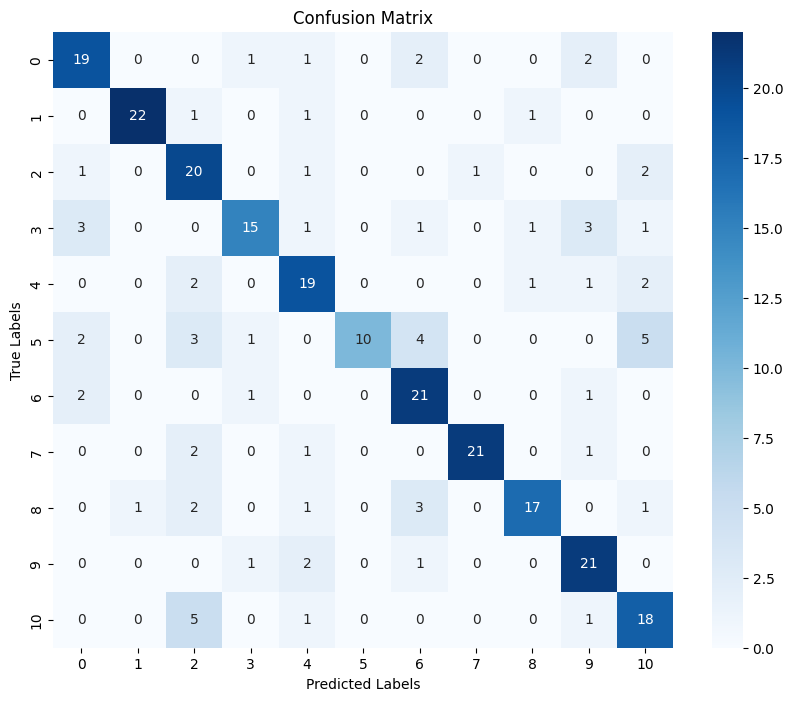

In [9]:
# prompt: Make use of a model to test the model is predict correcly

import matplotlib.pyplot as plt
# Evaluation on the test set
model.eval()
test_loss = 0.0
correct = 0
total = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = 100 * correct / total
test_loss = test_loss / len(test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

# Print some example predictions and labels
num_examples = 5  # Change to show more or fewer examples
for i in range(num_examples):
    print(f"Example {i+1}: Predicted Label - {all_predictions[i]}, True Label - {all_labels[i]}")

# Optionally, you can create a confusion matrix to visualize the model's performance
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [10]:
# prompt: I already train it Save me a model file I need to show in streamlit

import torch

# Assuming 'model' is your trained PyTorch model
torch.save(model.state_dict(), 'csgo_weapon_classifier.pth')
